# Quantum Kernel Methods

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Kernel-based Classification with Paddle Quantum

> It is required to have [`sklearn`](https://scikit-learn.org/stable/install.html) packages installed for the support vector machine. Readers may run the following block to install the relevant packages:

In [13]:
from IPython.display import clear_output
clear_output()

In this tutorial, we will demonstrate how to classify data using a support vector machine with a kernel computed by Paddle Quantum.

In [17]:
import time
import matplotlib
import numpy as np
import paddle
from numpy import pi as PI
from matplotlib import pyplot as plt

import sklearn
from sklearn import svm
from sklearn.datasets import fetch_openml, make_moons, make_circles
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from tqdm import tqdm

from paddle import matmul, transpose
from paddle_quantum.ansatz import Circuit
from paddle_quantum.gate import IQPEncoding
import paddle_quantum

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

For the training and testing set, we generate some 2D circle data that has 2 classes.

In [15]:
# Generate data set
# X_train, y_train = make_circles(10, noise=0.05, factor=0.2, random_state=0)
# X_test, y_test = make_circles(10, noise=0.05, factor=0.2, random_state=1024)

# # Visualize respectively the training and testing set
# fig, ax = plt.subplots(1, 2, figsize=[10, 4])
# ax[0].scatter(X_train[:,0], X_train[:,1], 
#               marker='o', c = matplotlib.cm.coolwarm(np.array(y_train, dtype=np.float32)))
# ax[0].set_title('Train')
# ax[1].set_title('Test')
# ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', c = matplotlib.cm.coolwarm(np.array(y_test, dtype=np.float32)))

# print("Let's first see our training and testing set:")

X_train = np.loadtxt("trainX.txt")
y_train = np.loadtxt("trainY.txt")
X_test = np.loadtxt("testX.txt")
y_test = np.loadtxt("testY.txt")

X_train = X_train[:100]
y_train = y_train[:100]

In [18]:
# Initialize the progress bar
bar_format_string = '{l_bar}{bar}|[{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]'
pbar = tqdm(total=100, bar_format=bar_format_string)
pbar.close()
clear_output()

Now, let's see how to implement a quantum kernel with Paddle Quantum:

In [19]:
# Global variable for manual updates of the progress bar
N = 1

# The QKE circuit simulated by paddle quantum
def q_kernel_estimator(x1, x2):
    
    # Transform data vectors into tensors
    x1 = paddle.to_tensor(x1)
    x2 = paddle.to_tensor(x2)
    
    # Create the circuit
    cir = paddle_quantum.ansatz.Sequential()
    
    # Add the encoding circuit for the first data vector
    cir.append(IQPEncoding(qubits_idx=[[0,1]], feature=x1))
    init_state = paddle_quantum.state.zero_state(2)
    state = cir[0](state=init_state)    
    
    # Add inverse of the encoding circuit for the second data vector
    cir.append(IQPEncoding(qubits_idx=[[0,1]], feature=x2))
    fin_state = cir[1](state=state,invert=True).data
    
    # Update the progress bar
    global N
    pbar.update(100/N)
    
    # Return the probability of measuring 0...0 
    return (fin_state[0].conj() * fin_state[0]).real().numpy()[0]

# Define a kernel matrix function, for which the input should be two list of vectors
# This is needed to customize the SVM kernel
def q_kernel_matrix(X1, X2):
    return np.array([[q_kernel_estimator(x1, x2) for x2 in X2] for x1 in X1])

# Visualize the decision function, boundary, and margins of +- 0.2
def visualize_decision_bound(clf):
    
    # Create a 10x10 mesh in the data plan 
    x_min, x_max = X_train[:,0].min(), X_train[:,0].max()
    y_min, y_max = X_train[:,1].min(), X_train[:,1].max()
    XX, YY = np.meshgrid(np.linspace(-1.2, 1.2, 10), 
                         np.linspace(-1.2, 1.2, 10))
    
    # Calculate the decision function value on the 10x10 mesh
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Z.reshape(XX.shape)
    
    # visualize the decision function and boundary
    clear_output()
    plt.contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=matplotlib.cm.coolwarm, alpha=1)
    plt.scatter(X_train[:,0], X_train[:,1], 
                c = matplotlib.cm.coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor='black')
    plt.scatter(X_test[:,0], X_test[:,1], marker='v', 
                c = matplotlib.cm.coolwarm(np.array(y_test, dtype=np.float32)),
               edgecolor='black')
    plt.contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])

# To make sure we didn't make any mistake, check if the kernel function satisfies K(x, x)=1
print('Check if K(x, x) = 1?',
      bool(abs(q_kernel_estimator(np.array([1. ,1.]), np.array([1., 1.])) - 1) < 1e-6))

NameError: name 'paddle_quantum' is not defined

Then, let's try to use a support vector machine with a quantum kernel (QKE-SVM) to classify our data:

Let's see how the QKE-SVM performs on the training on both the training and testing data:


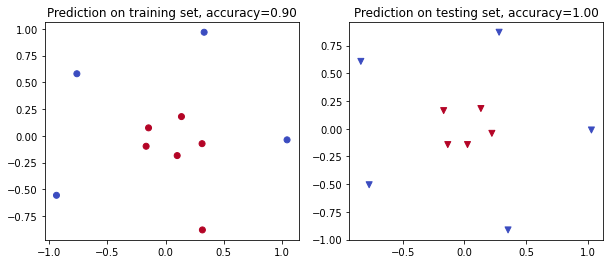

In [8]:
# Create the progress bar and the total kernel evaluation number N needed for training and prediction
pbar = tqdm(total=100, 
            desc='Training and predicting with QKE-SVM', 
            bar_format=bar_format_string)
N = len(X_train) ** 2 + len(X_train) ** 2 + len(X_train) * len(X_test)

# Create a support vector machine with a quantum kernel
svm_qke = svm.SVC(kernel=q_kernel_matrix)

# Train the svm with training data
svm_qke.fit(X_train, y_train)

# See how the svm classifies the training and testing data
predict_svm_qke_train = svm_qke.predict(X_train)
predict_svm_qke_test = svm_qke.predict(X_test)

# Calculate the accuracy
accuracy_train = np.array(predict_svm_qke_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test = np.array(predict_svm_qke_test == y_test, dtype=int).sum()/len(y_test)

# Visualize the result
pbar.close()
clear_output()
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_qke_train, dtype=np.float32)))
ax[0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train))
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_qke_test, dtype=np.float32)))
ax[1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test))
print("Let's see how the QKE-SVM performs on the training on both the training and testing data:")

We can also visualize the decision function, also the decision boundary with margins of $\pm 0.2$:

Calculating the decision function of QKE-SVM: 100%|██████████████████████████████▉|[00:09<00:00, 10.96it/s]


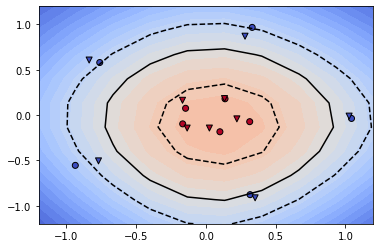

In [9]:
# Create the progress bar and the total kernel evaluation number N needed for visualizing the decision function
pbar = tqdm(total=100, 
            desc='Calculating the decision function of QKE-SVM', 
            bar_format=bar_format_string)
N = 10 ** 2 * len(X_train)
    
# Visualize the decision function
visualize_decision_bound(svm_qke)
pbar.close()

We can see that the quantum kernel has the ability to learn non-linearity correctly. As a matter of fact, the performance of quantum kernel methods in classification depends on whether the quantum feature map can distinguish non-trivial patterns hidden in the data. Currently, people are still exploring how to design a good quantum kernel: First, we may try different designs of encoding circuits; Second, we can train the quantum feature map to improve its classification accuracy [5-6]; Finally, we can also try variants of the quantum kernels [7]. 

In the following part, we will introduce another special kind of quantum kernel - projected quantum kernel. 

### Projected quantum kernel

It was mentioned above that quantum kernel methods can potentially distinguish intractable patterns by mapping classical data vectors into a quantum feature space via a quantum feature map. However, as the quantum feature space - the Hilbert space's dimensionality grows exponentially with the number of qubits, nearly all quantum states will be perpendicular to each other when we have a large number of qubits. Then the kernel matrix will just become an identity matrix $K_{ij} = K(\mathbf{x}_j, \mathbf{x}_i) \sim {I}$, and the kernel methods would fail. To avoid this problem caused by extra dimensionality, we first need to extract features from the Hilbert space and then construct the kernel function with these extracted features. Following this idea, a variant of quantum kernel - projected quantum kernel is proposed : By projecting the quantum feature vectors back into the classical space with a set of measurements, the dimensionality problem is mitigated [7]. Also, as the projection can preserve important features of the quantum feature space, the projected kernel can still gain a quantum advantage. 

There are several kinds of projected quantum kernels, here we choose the most rudimentary one:

$$
K^{P}(x_i,x_j) = \exp\left(-\gamma\sum\limits_{k}\sum\limits_{P\in \mathcal{M}}( {\rm Tr} (P\rho(x_i)_k)-{\rm Tr}(P\rho(x_j)_k))^{2}\right),
\tag{13}
$$

where $\rho(x_i)_k$ is the reduce density matrix of qubits $k$, $\mathcal{M}$ a set of measurements on the reduce density matrix. Here we take $k = 0, 1$ and $M = \{X, Y, Z \}$, which means using Pauli measurements to measure every single qubit at the output.

Let's first try to implement a projected quantum kernel circuit with Paddle Quantum:

In [10]:
# First we can create a circuit to calculate the feature map 
def projected_q_feature_map(x):
    # turn data into tensor
    x = paddle.to_tensor(x)
    
    # Update the progress bar
    global N
    pbar.update(100/N)
    
    init_state = paddle_quantum.state.zero_state(2)

    res = []
    #　Take a projected measurement, returning its expected value as a classical feature
    for op_pauli in ['z0', 'z1', 'x0', 'x1', 'y0', 'y1']:
        cir = paddle_quantum.ansatz.Sequential()
        cir.append(IQPEncoding(qubits_idx=[[0, 1]], feature=x))
        state = cir[0](init_state)
        hamiltonian = paddle_quantum.Hamiltonian([[1.0, op_pauli]])
        cir.append(paddle_quantum.loss.ExpecVal(hamiltonian))
        res.append(cir[1](state).numpy()[0])
    return res

# to compute the projected quantum kernel based on the feature vectors
def p_quantum_kernel_estimator(x1, x2):
    
    # compute the feature vector of each data and return the kernel function value
    p_feature_vector_1 = np.array(projected_q_feature_map(x1))
    p_feature_vector_2 = np.array(projected_q_feature_map(x2))
    
    return np.exp(-((p_feature_vector_1 - p_feature_vector_2) ** 2).sum())

# similarly, define the kernel matrix as required 
def p_quantum_kernel_matrix(X1, X2):
    return np.array([[p_quantum_kernel_estimator(x1, x2) for x2 in X2] for x1 in X1])

Then, we replace the quantum kernel in the support vector machine with a projected quantum kernel, and see how the projected kernel performs on this classification task:

Let's see how the PQK-SVM performs on the training on both the training and testing data:


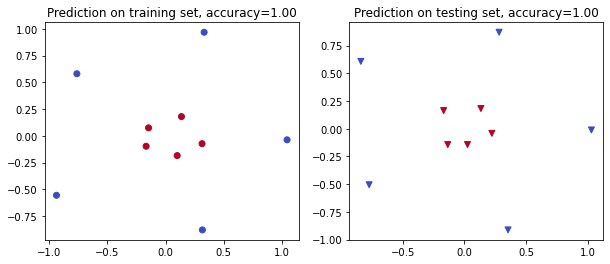

In [11]:
# Set the progress bar and the total kernel evaluation number N needed for training and prediction
pbar = tqdm(total=100, 
            desc='Training and predicting with PQK-SVM', 
            bar_format=bar_format_string)
N = 2 * (len(X_train) ** 2 + len(X_train) ** 2 + len(X_train) * len(X_test))

# Create a support vector machine with a quantum kernel
svm_pqk = svm.SVC(kernel=p_quantum_kernel_matrix)

# Train the svm with training data
svm_pqk.fit(X_train, y_train)

# See how the svm classifies the training and testing data
predict_svm_pqk_train = svm_pqk.predict(X_train)
predict_svm_pqk_test = svm_pqk.predict(X_test)

# Calculate the accuracy
accuracy_train = np.array(predict_svm_pqk_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test = np.array(predict_svm_pqk_test == y_test, dtype=int).sum()/len(y_test)

# Visualize the result
pbar.close()
clear_output()
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_pqk_train, dtype=np.float32)))
ax[0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train))
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = matplotlib.cm.coolwarm(np.array(predict_svm_pqk_test, dtype=np.float32)))
ax[1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test))
print("Let's see how the PQK-SVM performs on the training on both the training and testing data:")

Let's also check the decision function given by the PQK-SVM:

Calculating the decision function for PQK-SVM: 100%|█████████████████████████████▉|[01:17<00:00,  1.29it/s]


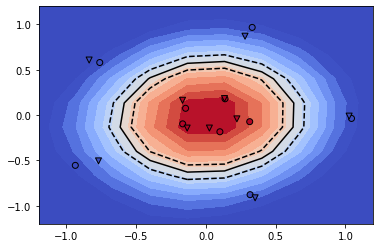

In [12]:
# Set the progress bar and the total kernel evaluation number N needed for visualizing the decision function
pbar = tqdm(total=100, 
            desc='Calculating the decision function for PQK-SVM', 
            bar_format=bar_format_string)
N = 2 * 10 ** 2 * len(X_train)
    
# Clear the progress bar and visualize the decision function
visualize_decision_bound(svm_pqk)
pbar.close()

## Conclusion

In quantum machine learning, people hope the design learning models which can gain quantum advantage by exploring the nature of quantum mechanics' laws. Recently, many connections are made  between these quantum models and kernel methods, one of the most important classical machine learning approaches. In comparison to considering a parameterized quantum circuit as a "quantum neural network", where we focus on the variational ansatz $U(\theta)$, the quantum kernel methods emphasize the importance of quantum feature map $U(x)$, which describes how the classical data vectors is mapped to the quantum states. This brings new perspectives to how we can design novel quantum machine learning algorithms. Therefore, we encourage readers to together explore the performance of various quantum kernel designs on different data sets.


---

## References

[1] Schuld, Maria. "Supervised quantum machine learning models are kernel methods." arXiv preprint [arXiv:2101.11020 (2021)](https://arxiv.org/abs/2101.11020).

[2] Havlíček, Vojtěch, et al. "Supervised learning with quantum-enhanced feature spaces." [Nature 567.7747 (2019): 209-212](https://arxiv.org/abs/1804.11326).

[3] Liu, Yunchao, Srinivasan Arunachalam, and Kristan Temme. "A rigorous and robust quantum speed-up in supervised machine learning." arXiv preprint [arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174).

[4] Schuld, Maria, and Nathan Killoran. "Quantum machine learning in feature Hilbert spaces." [Phys. Rev. Lett. 122.4 (2019): 040504](https://arxiv.org/abs/1803.07128).

[5] Hubregtsen, Thomas, et al. "Training Quantum Embedding Kernels on Near-Term Quantum Computers." arXiv preprint [arXiv:2105.02276(2021)](https://arxiv.org/abs/2105.02276).

[6] Glick, Jennifer R., et al. "Covariant quantum kernels for data with group structure." arXiv preprint [arXiv:2105.03406(2021)](https://arxiv.org/abs/2105.03406).

[7] Huang, Hsin-Yuan, et al. "Power of data in quantum machine learning." arXiv preprint [arXiv:2011.01938 (2020)](https://arxiv.org/abs/2011.01938).

[8] Schölkopf, Bernhard, and Alexander J. Smola"Learning with kernels: support vector machines, regularization, optimization, and beyond." [MIT Press(2002)](https://mitpress.mit.edu/books/learning-kernels).